In this section we will build a BERT fine tuned model which we will train on a dataset that comprises of about 200,000 news headlines from HuffPost from 2012 to 2018.  We have more than 40 different types of news in total.  

(A) To begin, we first need to install the transformers library from which we can download the BERT pretrained model and also import all the necessary libraries to work.

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 4.5 MB/s 
     |████████████████████████████████| 3.3 MB 15.7 MB/s 
     |████████████████████████████████| 895 kB 52.1 MB/s 
     |████████████████████████████████| 636 kB 34.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#importing all the necessary libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import io
from google.colab import files
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
import transformers ## for bert language model
from transformers import TFAutoModel, AutoTokenizer, BertConfig, TFBertModel
import re
import os
import random
import itertools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K



(B) Our dataset is stored in the google drive so we will mount our drive to the colab to access files from there smoothly and will load the dataset into a dataframe.

In [ ]:
# Mounting the google drive to access the dataset stored in the drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
path = "/gdrive/My Drive/Colab Notebooks/News_Category_Dataset_v2"

In [ ]:
#Loading the dataset into df dataframe.
df = pd.read_json('/content/gdrive/MyDrive/Colab Notebooks/News_Category_Dataset_v2.json', lines='True') 

(C) In our dataset there are many news categories which are very close to each other in meaning. For example, we have "Arts and Culture" and "Arts" as two separate categories which is not required as they both contain the same type of context. Another example are the categories "College" and "Education". So the first step is to reduce the number of categories by combining the ones very close to each other under one single roof for which we are using a groupper method which will receive the categories to group and the new name for the combined category as input. 

In [ ]:
# from https://www.kaggle.com/derinrobert/newsclassification-using-lstm
categories = df['category'].value_counts().index

def groupper(grouplist,name):
    for ele in categories:
        if ele in grouplist:
            df.loc[df['category'] == ele, 'category'] = name

In [ ]:
groupper( grouplist= ['BUSINESS' ,  'MONEY'] , name =  'FINANCE')

groupper( grouplist= ['THE WORLDPOST' , 'WORLDPOST' , 'WORLD NEWS'] , name =  'WORLDNEWS')

groupper( grouplist= ['ENVIRONMENT' ,'GREEN'] , name =  'ENVIRONMENT')

groupper( grouplist= ['TECH', 'SCIENCE'] , name =  'TECHNOLOGY')

groupper( grouplist= ['WELLNESS', 'HEALTHY LIVING'] , name =  'HEALTH')

groupper( grouplist= [ 'PARENTING', 'PARENTS'] , name =  'PARENTING')

groupper( grouplist= [ 'EDUCATION' ,'COLLEGE'] , name =  'EDUCATION')

groupper( grouplist= ['FOOD & DRINK', 'TASTE'] , name =  'FOOD')

groupper( grouplist= ['STYLE & BEAUTY' ,'STYLE'] , name =  'STYLE')

groupper( grouplist= ['ARTS & CULTURE','CULTURE & ARTS','ARTS'] , name =  'ART-CULTURE')

groupper( grouplist= ['WOMEN','QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES'] , name =  'EMPOWERED VOICES')

groupper( grouplist= ['HOME & LIVING','TRAVEL'] , name =  'TRAVEL AND LIVING')

groupper( grouplist= ['WEDDINGS', 'DIVORCE'] , name =  'MARRIAGE')

groupper( grouplist= ['SPORTS','ENTERTAINMENT' , 'COMEDY','WEIRD NEWS'] , name =  'SPORTS AND ENTERTAINMENT')

groupper( grouplist= ['FIFTY' , 'IMPACT' ,'GOOD NEWS','MEDIA'] , name =  'GENERAL')

groupper( grouplist= ['CRIME',  'RELIGION'] , name =  'CRIME AND RELIGION')

(D) As seen in the exploratory data analysis ipynb file that we are dealing with an imbalanced dataset since the four most well represented categories "Politics", "Sports and Entertainment", "Health" and "Empowered Voices" make up 50 percent of all the data samples. So we need to balance our dataset so as to not result in bias decisions. In order to have dataset balanced we are taking equal number of rows for every category. Then we will use a single integer for representing a class or category to be fed to the model.

In [ ]:
# since we have imbalanced dataset, we will be taking equal number of rows from every category.
# taken from https://www.kaggle.com/imdevskp/news-category-classification
# container for dfs
dfs = []

# we will loop through every category and take a sample of 2140 rows from each category as 2140 is the minimum number available for each category
for category in df['category'].unique():
    temp = df[df['category']==category]
    dfs.append(temp.sample(2140)) 
    
# concatenate dataframes
df = pd.concat(dfs)

# shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)

# first few rows
df.head()

,category,headline,authors,link,short_description,date
0,CRIME AND RELIGION,More Than A Dozen Jewish Centers Hit With Anon...,Carol Kuruvilla,https://www.huffingtonpost.com/entry/jewish-co...,The calls to Jewish schools and centers in nin...,2017-01-10
1,STYLE,Mindy Kaling Has No Problem Shaking The Fashio...,Emily Tess Katz,https://www.huffingtonpost.com/entry/mindy-kal...,,2014-09-15
2,CRIME AND RELIGION,Passengers Brawl TWICE On All Nippon Airways J...,Ron Dicker,https://www.huffingtonpost.com/entry/passenger...,Just once wasn't enough!?,2017-05-02
3,SPORTS AND ENTERTAINMENT,Someone Give Mo Lowda & The Humble A Record De...,Isaac Saul,https://www.huffingtonpost.com/entry/mo-lowda-...,,2014-07-22
4,POLITICS,HuffPost Rise: What You Need To Know On June 13,,https://www.huffingtonpost.com/entry/huffpost-...,Welcome to the HuffPost Rise Morning Newsbrief...,2016-06-13


In [ ]:
# we are converting the category into a single integer for representing it instead of one-hot encoded vector as it will take more time and space.
map_label = dict(enumerate(df.category.factorize()[1]))
df['category_no'] = df.category.factorize()[0]

print(df.shape)
df.head()

(36380, 7)


,category,headline,authors,link,short_description,date,category_no
0,CRIME AND RELIGION,More Than A Dozen Jewish Centers Hit With Anon...,Carol Kuruvilla,https://www.huffingtonpost.com/entry/jewish-co...,The calls to Jewish schools and centers in nin...,2017-01-10,0
1,STYLE,Mindy Kaling Has No Problem Shaking The Fashio...,Emily Tess Katz,https://www.huffingtonpost.com/entry/mindy-kal...,,2014-09-15,1
2,CRIME AND RELIGION,Passengers Brawl TWICE On All Nippon Airways J...,Ron Dicker,https://www.huffingtonpost.com/entry/passenger...,Just once wasn't enough!?,2017-05-02,0
3,SPORTS AND ENTERTAINMENT,Someone Give Mo Lowda & The Humble A Record De...,Isaac Saul,https://www.huffingtonpost.com/entry/mo-lowda-...,,2014-07-22,2
4,POLITICS,HuffPost Rise: What You Need To Know On June 13,,https://www.huffingtonpost.com/entry/huffpost-...,Welcome to the HuffPost Rise Morning Newsbrief...,2016-06-13,3


In [ ]:
#Finally we are left with 17 categories having equal number of rows.
print("We have a total of {} categories".format(df['category'].nunique()))
df['category'].value_counts()

We have a total of 17 categories


FINANCE                     2140
GENERAL                     2140
TECHNOLOGY                  2140
HEALTH                      2140
SPORTS AND ENTERTAINMENT    2140
EMPOWERED VOICES            2140
MARRIAGE                    2140
FOOD                        2140
CRIME AND RELIGION          2140
ART-CULTURE                 2140
WORLDNEWS                   2140
TRAVEL AND LIVING           2140
EDUCATION                   2140
ENVIRONMENT                 2140
PARENTING                   2140
STYLE                       2140
POLITICS                    2140
Name: category, dtype: int64

(E) BERT expects its input data in a particular format as it is a pre-trained model, so we need to convert data in the format suitable for BERT. This will require the generation of tokenizations, mask and segment id's. Then we will Split the dataset in the standard ratio and obtain the train and test dataset.

In [ ]:
### UTILITY FUNCTIONS FOR TOKENIZATIONS, MASKS AND SEGMENTS CREATION ###
### from: https://www.kaggle.com/akensert/bert-base-tf2-0-now-huggingface-transformer

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def convert_to_transformer_inputs(str1, str2, tokenizer, max_sequence_length, double=True):
    
    def return_id(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,
            add_special_tokens=True,
            max_length=length,
            truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_masks = [1] * len(input_ids)
        input_segments = inputs["token_type_ids"]
        
        padding_length = length - len(input_ids)
        padding_id = tokenizer.pad_token_id
        
        input_ids = input_ids + ([padding_id] * padding_length)
        input_masks = input_masks + ([0] * padding_length)
        input_segments = input_segments + ([0] * padding_length)
        
        return [input_ids, input_masks, input_segments]
    
    if double:
    
        input_ids_1, input_masks_1, input_segments_1 = return_id(
            str1, None, 'longest_first', max_sequence_length)

        input_ids_2, input_masks_2, input_segments_2 = return_id(
            str2, None, 'longest_first', max_sequence_length)

        return [input_ids_1, input_masks_1, input_segments_1,
                input_ids_2, input_masks_2, input_segments_2]
    
    else:
        
        input_ids, input_masks, input_segments = return_id(
            str1, str2, 'longest_first', max_sequence_length)

        return [input_ids, input_masks, input_segments,
                None, None, None]        

def compute_input_arrays(df, columns, tokenizer, max_sequence_length, double=True):
    
    input_ids_1, input_masks_1, input_segments_1 = [], [], []
    input_ids_2, input_masks_2, input_segments_2 = [], [], []
    for _, instance in tqdm(df[columns].iterrows(), total=len(df)):
        str1, str2 = instance[columns[0]], instance[columns[1]]

        ids_1, masks_1, segments_1, ids_2, masks_2, segments_2 = \
        convert_to_transformer_inputs(str1, str2, tokenizer, max_sequence_length, double=double)
        
        input_ids_1.append(ids_1)
        input_masks_1.append(masks_1)
        input_segments_1.append(segments_1)

        input_ids_2.append(ids_2)
        input_masks_2.append(masks_2)
        input_segments_2.append(segments_2)
        
    if double:
        
        return [np.asarray(input_ids_1, dtype=np.int32), 
                np.asarray(input_masks_1, dtype=np.int32), 
                np.asarray(input_segments_1, dtype=np.int32),
                np.asarray(input_ids_2, dtype=np.int32), 
                np.asarray(input_masks_2, dtype=np.int32), 
                np.asarray(input_segments_2, dtype=np.int32)]
    
    else:
        
        return [np.asarray(input_ids_1, dtype=np.int32), 
                np.asarray(input_masks_1, dtype=np.int32), 
                np.asarray(input_segments_1, dtype=np.int32)]

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df[['headline','short_description']], df['category_no'].values, 
                                                    random_state=33, test_size = 0.3)
#del df

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(25466, 2) (10914, 2)
(25466,) (10914,)


(F) From the exploratory data analysis we had obtained the suitable maximum sequence length of our BERT model should be 75. So we will use it and we will download the 'bert base' tokenizer which will perform all the preprocessing needed for the BERT model.

In [ ]:
### IMPORT TOKENIZER ###

MAX_SEQUENCE_LENGTH = 75

tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
#An example showing how the tokenizer works on the input.
text = ["this is an example to describe the tokenizer", "We are using bert-base tokenizer"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 2019, 2742, 2000, 6235, 1996, 19204, 17629, 102], [101, 2057, 2024, 2478, 14324, 1011, 2918, 19204, 17629, 102, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]}


In [ ]:
#generating the input into the suitable format with the help of the function created earlier.
input_train = compute_input_arrays(X_train, ['headline','short_description'], tokenizer, MAX_SEQUENCE_LENGTH, double=False)
input_test = compute_input_arrays(X_test, ['headline','short_description'], tokenizer, MAX_SEQUENCE_LENGTH, double=False)

  0%|          | 0/25466 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/10914 [00:00<?, ?it/s]

(G) We will download the pre trained BERT model which is accessible as a Tensorflow model subclass which we can easily pull in our network architecture for fine-tuning. We perform the average-pooling operation which reduces the final hidden state of the transformer. Average pooling is a pooling operation which is used for making a downsampled or pooled feature map by calculating the average value of patches of feature map. Finally we add a dense layer to calculate the probability scores. A dense layer is a deeply connected neural network layer and is frequently used to change the vector dimensions.

In our case we have a multi class classification problem for which usually categorical crossentropy loss function is used but it requires the labels to be in one-hot encoded format. So the other alternative is sparse categorical crossentropy which also performs the same type of loss as categorical entropy but it works on integers and does not require the target to be on-hot encoded. In this way, we save time in memory and also in computation since we use a single integer for representing a class rather than a whole vector. So, we have taken sparse categorical crossentropy as our loss function.The learning rate of 2.0e-5 is appropriate to overcome the Catastrophic forgetting problem. So we have taken 2.0e-5 as the learning rate for our model.

For optimization, we have taken Adam optimizer which is an extension of stochastic gradient descent as for different parameters it computes individual learning rates. In order to adapt the learning rate for each weight in the network, it uses the estimations of first and second moments of gradient. It is well suited in scenarios where we have large amount of data or parameters. Apart from this since it requires little memory and is invariant to diagonal re-scale if gradients and has many other advantages it is one of the best optimization methods.

We are making use of the softmax activation function. Softmax is really useful when we deal with multiclass classification problems and is a more generalised form of sigmoid activation funcion. It provides output in the range of 0 to 1 because of which it is used a final layer in the classification models.

In [ ]:
def simple_bert():
    
    set_seed(33)
    
    opt = Adam(learning_rate=2e-5)
    
    id_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    mask_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    atn_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig()
    config.output_hidden_states = False # Set to True to obtain hidden states
    bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)
    
    embedding = bert_model(id_, attention_mask=mask_, token_type_ids=atn_)[0]
    
    x = GlobalAveragePooling1D()(embedding)    
    x = Dropout(0.2)(x)
    out = Dense(len(map_label), activation='softmax')(x)

    model = Model(inputs=[id_, mask_, atn_], outputs=out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)
    
    return model

In [ ]:
model = simple_bert()
model.summary()

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

(H) Training and Prediction - We then train our data with 3 epochs on our input data and then make predictions for the test data.

In [ ]:
model.fit(input_train, y_train, epochs=3, batch_size=6)

Epoch 1/3
4245/4245 [==============================] - 575s 132ms/step - loss: 1.1351
Epoch 2/3
4245/4245 [==============================] - 564s 133ms/step - loss: 0.6302
Epoch 3/3
4245/4245 [==============================] - 565s 133ms/step - loss: 0.3104


In [ ]:

### PREDICT TEST ###

pred_test = np.argmax(model.predict(input_test), axis=1)

In [ ]:
print(classification_report([map_label[i] for i in y_test], [map_label[i] for i in pred_test]))

                          precision    recall  f1-score   support

             ART-CULTURE       0.80      0.66      0.72       679
      CRIME AND RELIGION       0.75      0.69      0.72       631
               EDUCATION       0.85      0.71      0.77       673
        EMPOWERED VOICES       0.60      0.59      0.60       671
             ENVIRONMENT       0.73      0.78      0.75       654
                 FINANCE       0.65      0.68      0.66       609
                    FOOD       0.84      0.88      0.86       657
                 GENERAL       0.50      0.51      0.51       612
                  HEALTH       0.66      0.64      0.65       628
                MARRIAGE       0.87      0.89      0.88       608
               PARENTING       0.68      0.75      0.71       648
                POLITICS       0.67      0.67      0.67       639
SPORTS AND ENTERTAINMENT       0.54      0.68      0.60       644
                   STYLE       0.86      0.80      0.83       643
         

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

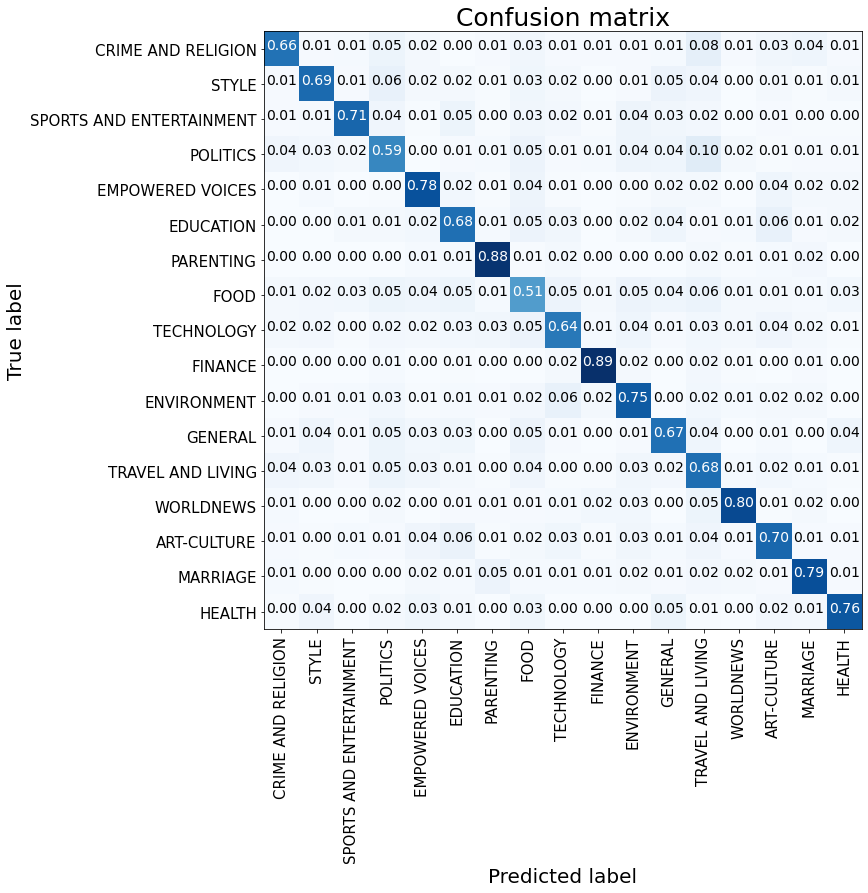

In [ ]:
cnf_matrix = confusion_matrix([map_label[i] for i in y_test], 
                              [map_label[i] for i in pred_test])

plt.figure(figsize=(11,11))
plot_confusion_matrix(cnf_matrix, classes=list(map_label.values()))
plt.show()

(I) Conclusion - Our Bert model provides a decent accuracy of 72% on the test data. BERT is providing a very good score of 0.80 for 'world news' category which means it is able to overcome all the drawbacks of machine learning algorithms as they provided low score for it around 0.27. So BERT is able to distinguish much better. It provides good score for other categories also like for finance with 0.89, environment as 0.75 and so on. This means that our BERT model is properly learning  the context  and semantics of  the  news articles  and provides suitable category for that particular news.